In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import collections
import sys

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers, models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scikeras.wrappers import KerasClassifier
from google.colab import drive


In [5]:
!pip install scikeras --upgrade

In [6]:
drive.mount('/content/gdrive')
drivePath = ('/content/gdrive/MyDrive/projects/data')
sys.path.append(drivePath)
os.chdir(drivePath)
current_dir = os.getcwd()
current_dir

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/content/gdrive/MyDrive/projects/data'

In [7]:
data_dir = "/content/gdrive/MyDrive/projects/data"
image_size = 128
labels_map = {"White": 0, "Black": 1, "Asian": 2, "Indian": 3}

In [8]:
# Fungsi untuk mengekstraksi fitur warna kulit
def extract_skin_color_feature(img):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Menambahkan lebih banyak rentang untuk mendeteksi lebih banyak variasi kulit
    skin_ranges = [
        # Light to tan
        (np.array([0, 20, 70], dtype=np.uint8), np.array([20, 255, 255], dtype=np.uint8)),
        # Medium/darker
        (np.array([0, 30, 40], dtype=np.uint8), np.array([20, 200, 150], dtype=np.uint8)),
        # Very dark
        (np.array([0, 40, 20], dtype=np.uint8), np.array([25, 255, 100], dtype=np.uint8)),
        # Range for light skin tones (White/Indian)
        (np.array([0, 10, 50], dtype=np.uint8), np.array([10, 255, 255], dtype=np.uint8)),   # Very light skin
        # Additional range for darker tones
        (np.array([0, 40, 50], dtype=np.uint8), np.array([20, 255, 255], dtype=np.uint8)),   # Darker skin
    ]

    mask_total = np.zeros(img.shape[:2], dtype=np.uint8)
    for lower, upper in skin_ranges:
        mask = cv2.inRange(img_hsv, lower, upper)
        mask_total = cv2.bitwise_or(mask_total, mask)

    skin = cv2.bitwise_and(img, img, mask=mask_total)
    skin_pixels = skin[mask_total > 0]

    if len(skin_pixels) > 0:
        mean_skin_color = np.mean(skin_pixels, axis=0)  # [R, G, B]
    else:
        # fallback: pakai rata-rata seluruh gambar
        mean_skin_color = np.mean(img, axis=(0, 1))

    return mean_skin_color

# Memuat data dan preprocessing
print("\n🔄 Memuat data dan preprocessing...")

data = []
labels = []
skin_features = []

# Memeriksa distribusi gambar per label
label_counts = {label: 0 for label in labels_map.values()}

# Proses gambar dari dataset
for race_label in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, race_label)
    if not os.path.isdir(folder_path):
        continue

    label = labels_map.get(race_label)

    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            img = cv2.imread(img_path)

            # === DATA CLEANING ===
            if img is None:
                print(f"🧹 Gagal membaca gambar: {img_path}")
                continue
            if img.shape[0] < 50 or img.shape[1] < 50:
                print(f"🧹 Gambar terlalu kecil: {img_path}")
                continue
            if len(img.shape) != 3 or img.shape[2] != 3:
                print(f"🧹 Bukan gambar RGB: {img_path}")
                continue

            img = cv2.resize(img, (image_size, image_size))

            # === SKIN COLOR FEATURE EXTRACTION ===
            skin_color_feat = extract_skin_color_feature(img)
            skin_features.append(skin_color_feat)

            data.append(img)
            labels.append(label)

            # Update distribusi label
            label_counts[label] += 1

        except Exception as e:
            print(f"❌ Error loading {img_path}: {e}")

# Memeriksa distribusi label gambar
print(f"\nDistribusi label gambar: {label_counts}")

# Konversi arrays
X = np.array(data, dtype="float32") / 255.0
y = np.array(labels)
y = to_categorical(y, num_classes=4)
skin_features = np.array(skin_features, dtype="float32") / 255.0  # Normalisasi

print(f"✅ Total data setelah cleaning: {len(X)}")
print(f"✅ Bentuk fitur warna kulit: {skin_features.shape}")


🔄 Memuat data dan preprocessing...

Distribusi label gambar: {0: 2000, 1: 2000, 2: 2010, 3: 2000}
✅ Total data setelah cleaning: 8010
✅ Bentuk fitur warna kulit: (8010, 3)


In [9]:
# Variabel untuk data dan label
X = []
y = []

# Ukuran gambar yang diresize
IMG_SIZE = 128

# Load dan praproses gambar
for label_name, label_id in labels_map.items():
    folder_path = os.path.join(data_dir, label_name)

    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)

        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Baca grayscale
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))       # Resize
            X.append(img)
            y.append(label_id)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

# Convert ke numpy array
X = np.array(X)
y = np.array(y)

# Tambah 1 channel untuk grayscale
if len(X.shape) == 3:
    X = X[..., np.newaxis]

# Normalisasi pixel ke 0-1
X = X / 255.0

print("Shape X:", X.shape)
print("Shape y:", y.shape)

# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Buat CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(labels_map), activation='softmax')  # Output layer = 4 kelas
])

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluasi model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('\nTest accuracy:', test_acc)

Shape X: (8010, 128, 128, 1)
Shape y: (8010,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.3040 - loss: 1.4090 - val_accuracy: 0.4095 - val_loss: 1.2626
Epoch 2/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4528 - loss: 1.2113 - val_accuracy: 0.4713 - val_loss: 1.1863
Epoch 3/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5254 - loss: 1.0902 - val_accuracy: 0.5044 - val_loss: 1.1587
Epoch 4/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6407 - loss: 0.8948 - val_accuracy: 0.4956 - val_loss: 1.2602
Epoch 5/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7390 - loss: 0.6853 - val_accuracy: 0.5006 - val_loss: 1.3398
Epoch 6/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8327 - loss: 0.4775 - val_accuracy: 0.4644 - val_loss: 1.6458
Epoch 7/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8861 - loss: 0.3297 - val_accuracy: 0.4775 - val_loss: 1.8909
Epoch 8/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9610 - loss: 0.1577 - val_acc

In [10]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
# Reshape X to 2D for SMOTE and apply SMOTE
X_reshaped = X.reshape(X.shape[0], -1)
X_resampled, y_resampled = smote.fit_resample(X_reshaped, y)
# Reshape X back to its original shape
X = X_resampled.reshape(-1, image_size, image_size, 1)  # Assuming grayscale images
# If you have RGB images (3 channels), change the reshape to:
# X = X_resampled.reshape(-1, image_size, image_size, 3)

# One-hot encode y
y = to_categorical(y_resampled, num_classes=4)

In [11]:
from sklearn.utils import class_weight
y_int = np.argmax(y, axis=1)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_int),
    y=y_int
)
class_weight_dict = dict(enumerate(class_weights))

In [12]:
X = np.array(data)
y = to_categorical(labels, num_classes=4)

# Cek keseimbangan label
print("\n📊 Distribusi Label:")
print(collections.Counter(np.argmax(y, axis=1)))



📊 Distribusi Label:
Counter({np.int64(2): 2010, np.int64(3): 2000, np.int64(1): 2000, np.int64(0): 2000})


In [13]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Augmentasi Data
train_datagen = ImageDataGenerator(
     rotation_range=15,
     width_shift_range=0.5,
     height_shift_range=0.5,
     shear_range=0.2,
     zoom_range=[0.8, 1.2],
     horizontal_flip=True,
     brightness_range=[0.7, 1.3],
     fill_mode='nearest'
 )

#The line causing the error was over-indented. It should be aligned with the train_datagen assignment.
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

In [16]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam # Import Adam optimizer

def create_model_for_finetuning():
    # Gunakan input shape yang sesuai dengan ukuran gambar Anda dan 3 channel warna (meskipun grayscale, ResNet50 butuh 3 channel)
    # Anda mungkin perlu mengubah gambar grayscale menjadi RGB (ulangi channel)
    input_tensor = Input(shape=(image_size, image_size, 3))

    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

    # === Tahap 1: Bekukan base model ===
    for layer in base_model.layers:
        layer.trainable = False

    # Tambahkan custom layers di atas base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(4, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile dengan learning rate awal
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model, base_model # Kembalikan base_model juga untuk tahap fine-tuning

# --- Cara Menggunakan ---

# Pastikan X_train dan X_test memiliki 3 channel (RGB)
# Jika gambar Anda grayscale (bentuk (batch, size, size, 1)), Anda perlu mengubahnya


In [18]:
if X_train.shape[-1] == 1:
    X_train = np.repeat(X_train, 3, axis=-1)
    X_test = np.repeat(X_test, 3, axis=-1)

# Buat model dan base_model
model, base_model = create_model_for_finetuning() # Gunakan fungsi fine-tuning yang sudah dimodifikasi

# Early Stopping
early_stop_fine_tune = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # Naikkan patience sedikit

# Augmentasi Data Generator untuk Training
train_datagen = ImageDataGenerator(
     rotation_range=20, # Mungkin sedikit lebih agresif
     width_shift_range=0.2,
     height_shift_range=0.2,
     shear_range=0.2,
     zoom_range=[0.8, 1.2],
     horizontal_flip=True,
     brightness_range=[0.7, 1.3],
     fill_mode='nearest'
 )

# Generator untuk Data Training
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

# Generator untuk Data Validasi (biasanya tanpa augmentasi ekstensif)
val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow(X_test, y_test, batch_size=32)


# === Tahap 1: Latih hanya custom layers ===
print("=== Memulai Tahap 1: Melatih Custom Layers ===")
# Latih menggunakan generator data augmentasi
history_stage1 = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32, # Sesuaikan dengan ukuran dataset
    epochs=50, # Naikkan epoch maksimum
    validation_data=val_generator,
    validation_steps=len(X_test) // 32, # Sesuaikan dengan ukuran dataset
    callbacks=[early_stop_fine_tune]
)

# === Tahap 2: Unfreeze beberapa layer di base model dan fine-tune ===
print("\n=== Memulai Tahap 2: Fine-tuning Base Model ===")

# Tentukan berapa layer yang ingin di-unfreeze. Eksperimen dengan angka ini.
unfreeze_layers_count = 50 # Coba jumlah yang berbeda

# Temukan indeks layer yang akan di-unfreeze
unfreeze_start_index = len(base_model.layers) - unfreeze_layers_count
if unfreeze_start_index < 0:
    unfreeze_start_index = 0

for i, layer in enumerate(base_model.layers):
    if i >= unfreeze_start_index:
        layer.trainable = True
    else:
        layer.trainable = False

# Kompilasi ulang model dengan learning rate yang lebih rendah
model.compile(optimizer=Adam(learning_rate=0.00005), # Coba learning rate yang lebih rendah
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Latih kembali model menggunakan generator data augmentasi
history_stage2 = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=100, # Naikkan epoch maksimum
    validation_data=val_generator,
    validation_steps=len(X_test) // 32,
    callbacks=[early_stop_fine_tune]
)

# Evaluasi model akhir
loss, acc = model.evaluate(X_test, y_test)
print(f"\n🎯 Test Accuracy Setelah Fine-tuning: {acc:.4f}")

=== Memulai Tahap 1: Melatih Custom Layers ===
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_545']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


200/200 ━━━━━━━━━━━━━━━━━━━━ 61s 247ms/step - accuracy: 0.3814 - loss: 1.6167 - val_accuracy: 0.5406 - val_loss: 1.0735
Epoch 2/50
  1/200 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.4688 - loss: 1.3003

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4688 - loss: 1.3003 - val_accuracy: 0.5375 - val_loss: 1.0717
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 275ms/step - accuracy: 0.5089 - loss: 1.1380 - val_accuracy: 0.5844 - val_loss: 0.9837
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6562 - loss: 0.9418 - val_accuracy: 0.5850 - val_loss: 0.9784
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 205ms/step - accuracy: 0.5581 - loss: 1.0756 - val_accuracy: 0.6062 - val_loss: 0.9336
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5625 - loss: 1.1499 - val_accuracy: 0.6106 - val_loss: 0.9329
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 214ms/step - accuracy: 0.5636 - loss: 1.0557 - val_accuracy: 0.6100 - val_loss: 0.9543
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5000 - loss: 1.2977 - val_accuracy: 0.6137 - val_loss: 0.9494
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 38s 188ms/step - accuracy: 0.5733 - loss: 1.0290 - val_accuracy: 0

In [19]:
# Classification Report dan Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred_labels, target_names=labels_map.keys()))

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_545']
Received: inputs=Tensor(shape=(32, 128, 128, 3))
  warnings.warn(msg)


49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_545']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step

🧾 Classification Report:
              precision    recall  f1-score   support

       White       0.71      0.80      0.76       375
       Black       0.76      0.86      0.81       411
       Asian       0.80      0.73      0.76       394
      Indian       0.79      0.67      0.72       422

    accuracy                           0.76      1602
   macro avg       0.77      0.76      0.76      1602
weighted avg       0.77      0.76      0.76      1602




🧩 Confusion Matrix:


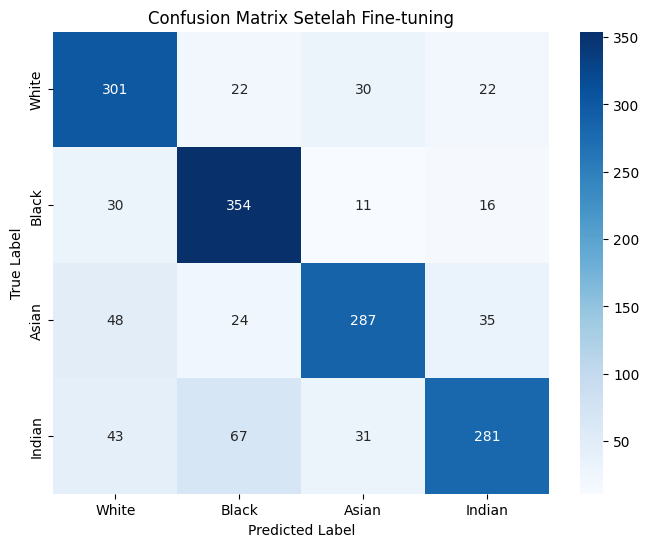

In [20]:
print("\n🧩 Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_map.keys(), yticklabels=labels_map.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Setelah Fine-tuning')
plt.show()

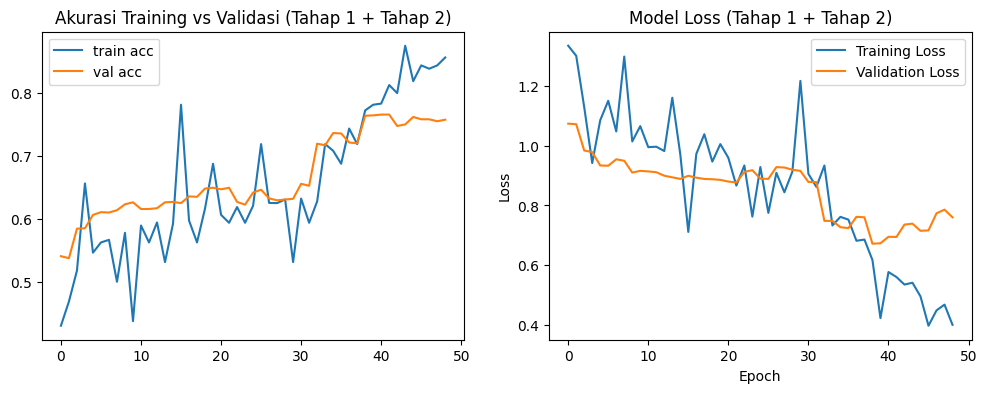

In [21]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_stage1.history['accuracy'] + history_stage2.history['accuracy'], label='train acc')
plt.plot(history_stage1.history['val_accuracy'] + history_stage2.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Akurasi Training vs Validasi (Tahap 1 + Tahap 2)')

plt.subplot(1, 2, 2)
plt.plot(history_stage1.history['loss'] + history_stage2.history['loss'], label='Training Loss')
plt.plot(history_stage1.history['val_loss'] + history_stage2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Tahap 1 + Tahap 2)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

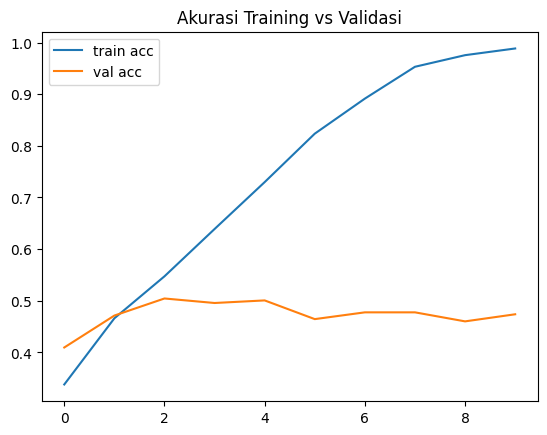

In [22]:
# Plot Akurasi
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Akurasi Training vs Validasi')
plt.show()


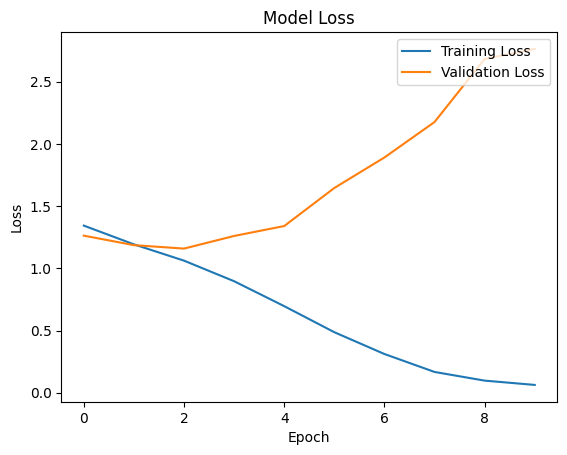

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Use the 'model' variable which contains the trained ResNet50 fine-tuned model
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred_labels)

# Now you can calculate accuracy per class
accuracy_per_class = cm.diagonal() / cm.sum(axis=1)
label_names = list(labels_map.keys())
for i, acc in enumerate(accuracy_per_class):
    print(f"Akurasi kelas {label_names[i]}: {acc:.2%}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Akurasi kelas White: 80.27%
Akurasi kelas Black: 86.13%
Akurasi kelas Asian: 72.84%
Akurasi kelas Indian: 66.59%


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step


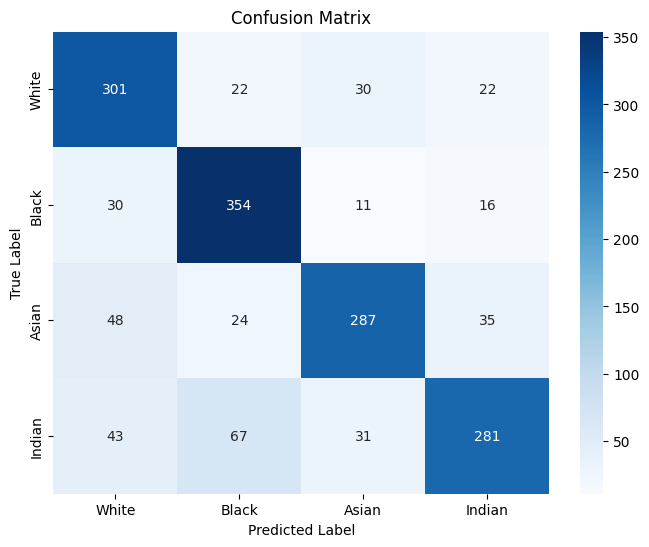

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Mengambil kelas dengan probabilitas tertinggi
y_true = np.argmax(y_test, axis=1)  # Mengambil kelas sebenarnya
cm = confusion_matrix(y_true, y_pred_classes)

# Tampilkan confusion matrix menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_map.keys(), yticklabels=labels_map.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [26]:
model.save('/content/gdrive/MyDrive/projects/model1_cnn.h5')